In [79]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import sys

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Loading Frey Faces 

In [1]:
data_path = '/home/andrei/ml/datasets/'

In [47]:
ff = scipy.io.loadmat(data_path + 'frey_rawface.mat', squeeze_me=True, struct_as_record=False)

In [48]:
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = ff["ff"].T
# .T.reshape((-1, img_rows, img_cols))

In [49]:
ff.shape

(1965, 560)

### Visualizing Frey Faces 

In [25]:
# from http://dohmatob.github.io/research/2016/10/22/VAE.html
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
    return figure

array([[  81.,  136.,  167., ...,  208.,   84.,  103.],
       [ 105.,  139.,  165., ...,  224.,  144.,   74.],
       [  56.,  126.,  161., ...,  225.,  180.,   98.],
       ..., 
       [ 204.,  160.,  126., ...,  149.,  141.,  140.],
       [ 152.,  154.,  129., ...,  159.,  137.,  141.],
       [  93.,  144.,  138., ...,  171.,  171.,  180.]])

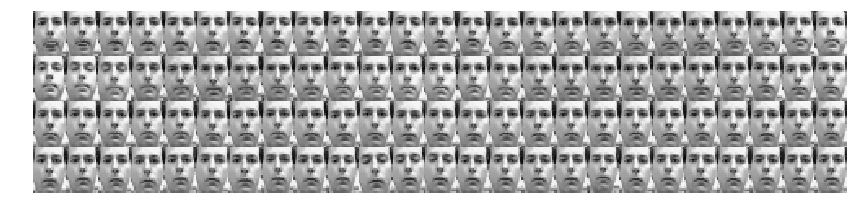

In [26]:
show_examples(ff, n=100, n_cols=25)

### Prepping the Data 

In [29]:
np.ceil(2/3)

1.0

In [74]:
class data_reader(object):
    
    def __init__(self,X,batch_size=1):
        self.X = X
        self.num_examples = X.shape[0]
        self.batch_number = 0 
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(X.shape[0] / batch_size))
    
    def next_batch(self):
        low_ix = self.batch_number*self.batch_size 
        up_ix = (self.batch_number + 1)*self.batch_size
        if up_ix >= self.X.shape[0]:
            up_ix = self.X.shape[0]
            self.batch_number = 0 # reset batch_number to zero
        else:
            self.batch_number = self.batch_number + 1
        return self.X[low_ix:up_ix,:]

In [75]:
batch_size = 100
ff_reader = data_reader(ff, batch_size)

In [76]:
ff_reader.num_batches

20

In [77]:
ff_reader.num_examples

1965

In [110]:
100*1965

196500

In [113]:
1e8

100000000.0

In [112]:
10**8

100000000

In [114]:
1e8 / 1965

50890.58524173028

### Training a VAE 

In [54]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, batch_norm

In [187]:
tf.reset_default_graph()

In [188]:
# Construction phase
n_inputs = 28*20
n_hidden1 = 200
n_hidden2 = 200
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn = tf.nn.elu,
        weights_initializer = tf.contrib.layers.variance_scaling_initializer()):
    X = tf.placeholder(tf.float32, shape = [None, n_inputs])
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2, activation_fn=tf.nn.tanh)
    hidden2_mean = fully_connected(hidden1, n_hidden2)
    hidden3_mean = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_sigma = tf.exp(0.5 * hidden3_gamma)
    noise1 = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
    hidden3 = hidden3_mean + hidden3_sigma * noise1
    hidden4 = fully_connected(hidden3, n_hidden4)
    hidden5 = fully_connected(hidden4, n_hidden5, activation_fn=tf.nn.tanh)
    hidden6_mean = fully_connected(hidden5, n_outputs, activation_fn=None)
    hidden6_gamma = fully_connected(hidden5, n_outputs, activation_fn=None)
    hidden6_sigma = tf.exp(0.5 * hidden6_gamma)
    noise2 = tf.random_normal(tf.shape(hidden6_sigma), dtype=tf.float32)
    outputs = hidden6_mean + hidden6_sigma * noise2

In [189]:
eps = 1e-10
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

reconstruction_loss = 0.5 * tf.reduce_sum(tf.square((X - hidden6_mean) / (eps + tf.exp(hidden6_gamma)))
                                  + tf.log(2*np.pi) + hidden6_gamma)
cost = reconstruction_loss + latent_loss
# display_cost = tf.reduce_mean(reconstruction_loss) + tf.reduce_mean(latent_loss)

In [190]:
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

In [191]:
init = tf.global_variables_initializer()

In [192]:
n_epochs = 10000
batch_size = 100
n_faces = 100
ff_reader = data_reader(ff, batch_size)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = ff_reader.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = ff_reader.next_batch().astype(np.float32)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([cost,
         reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val / X_batch.shape[0],
         "\tReconstruction loss:", reconstruction_loss_val / X_batch.shape[0],
          "\tLatent loss:", latent_loss_val / X_batch.shape[0])
    
    # generating digits
    codings_rnd = np.random.normal(size=[n_faces, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 104526.0 	Reconstruction loss: 104525.0 	Latent loss: 1.26524
1 Train total loss: 51553.2 	Reconstruction loss: 51551.8 	Latent loss: 1.39176
2 Train total loss: 30836.0 	Reconstruction loss: 30834.5 	Latent loss: 1.50664
3 Train total loss: 21107.3 	Reconstruction loss: 21105.6 	Latent loss: 1.689
4 Train total loss: 13683.8 	Reconstruction loss: 13682.0 	Latent loss: 1.76517
5 Train total loss: 10822.8 	Reconstruction loss: 10820.9 	Latent loss: 1.9505
6 Train total loss: 8354.94 	Reconstruction loss: 8352.92 	Latent loss: 2.02174
7 Train total loss: 7115.53 	Reconstruction loss: 7113.49 	Latent loss: 2.04047
8 Train total loss: 5779.65 	Reconstruction loss: 5777.43 	Latent loss: 2.21212
9 Train total loss: 4995.61 	Reconstruction loss: 4993.41 	Latent loss: 2.20239
10 Train total loss: 4456.75 	Reconstruction loss: 4454.52 	Latent loss: 2.23322
11 Train total loss: 3583.04 	Reconstruction loss: 3580.7 	Latent loss: 2.34063
12 Train total loss: 3509.67 	Reconstruc

102 Train total loss: 143.109 	Reconstruction loss: 139.738 	Latent loss: 3.37107
103 Train total loss: 143.724 	Reconstruction loss: 140.359 	Latent loss: 3.36491
104 Train total loss: 133.331 	Reconstruction loss: 129.988 	Latent loss: 3.34311
105 Train total loss: 134.938 	Reconstruction loss: 131.584 	Latent loss: 3.3539
106 Train total loss: 126.835 	Reconstruction loss: 123.44 	Latent loss: 3.39522
107 Train total loss: 131.933 	Reconstruction loss: 128.545 	Latent loss: 3.3886
108 Train total loss: 127.368 	Reconstruction loss: 123.972 	Latent loss: 3.39628
109 Train total loss: 125.269 	Reconstruction loss: 121.863 	Latent loss: 3.40615
110 Train total loss: 122.384 	Reconstruction loss: 119.04 	Latent loss: 3.3436
111 Train total loss: 117.288 	Reconstruction loss: 113.942 	Latent loss: 3.34674
112 Train total loss: 123.85 	Reconstruction loss: 120.472 	Latent loss: 3.37781
113 Train total loss: 130.161 	Reconstruction loss: 126.831 	Latent loss: 3.33052
114 Train total loss: 

203 Train total loss: 41.1787 	Reconstruction loss: 37.6347 	Latent loss: 3.54402
204 Train total loss: 38.7664 	Reconstruction loss: 35.2392 	Latent loss: 3.52726
205 Train total loss: 39.0923 	Reconstruction loss: 35.5707 	Latent loss: 3.52164
206 Train total loss: 37.3655 	Reconstruction loss: 33.8027 	Latent loss: 3.56278
207 Train total loss: 39.0135 	Reconstruction loss: 35.4556 	Latent loss: 3.55782
208 Train total loss: 38.4566 	Reconstruction loss: 34.9032 	Latent loss: 3.55338
209 Train total loss: 38.1087 	Reconstruction loss: 34.5436 	Latent loss: 3.5651
210 Train total loss: 36.8804 	Reconstruction loss: 33.3735 	Latent loss: 3.50697
211 Train total loss: 35.9035 	Reconstruction loss: 32.3998 	Latent loss: 3.50371
212 Train total loss: 37.3862 	Reconstruction loss: 33.8518 	Latent loss: 3.53443
213 Train total loss: 39.8638 	Reconstruction loss: 36.3806 	Latent loss: 3.48321
214 Train total loss: 40.6786 	Reconstruction loss: 37.1682 	Latent loss: 3.51041
215 Train total l

304 Train total loss: 17.5391 	Reconstruction loss: 14.0767 	Latent loss: 3.46236
305 Train total loss: 17.6689 	Reconstruction loss: 14.2175 	Latent loss: 3.45141
306 Train total loss: 17.2264 	Reconstruction loss: 13.7387 	Latent loss: 3.4877
307 Train total loss: 17.7396 	Reconstruction loss: 14.2568 	Latent loss: 3.48277
308 Train total loss: 17.5521 	Reconstruction loss: 14.0771 	Latent loss: 3.475
309 Train total loss: 17.4537 	Reconstruction loss: 13.972 	Latent loss: 3.48175
310 Train total loss: 17.03 	Reconstruction loss: 13.6036 	Latent loss: 3.42645
311 Train total loss: 16.6784 	Reconstruction loss: 13.2578 	Latent loss: 3.4206
312 Train total loss: 17.2077 	Reconstruction loss: 13.762 	Latent loss: 3.44567
313 Train total loss: 18.1434 	Reconstruction loss: 14.7548 	Latent loss: 3.38855
314 Train total loss: 18.4365 	Reconstruction loss: 15.0219 	Latent loss: 3.4146
315 Train total loss: 16.9541 	Reconstruction loss: 13.4913 	Latent loss: 3.46283
316 Train total loss: 17.

405 Train total loss: 10.4248 	Reconstruction loss: 7.39863 	Latent loss: 3.0262
406 Train total loss: 10.2352 	Reconstruction loss: 7.18769 	Latent loss: 3.04754
407 Train total loss: 10.4599 	Reconstruction loss: 7.41644 	Latent loss: 3.04346
408 Train total loss: 10.3455 	Reconstruction loss: 7.31271 	Latent loss: 3.03279
409 Train total loss: 10.3404 	Reconstruction loss: 7.3061 	Latent loss: 3.03431
410 Train total loss: 10.1502 	Reconstruction loss: 7.17462 	Latent loss: 2.97559
411 Train total loss: 10.011 	Reconstruction loss: 7.04035 	Latent loss: 2.97068
412 Train total loss: 10.2417 	Reconstruction loss: 7.25737 	Latent loss: 2.98435
413 Train total loss: 10.5584 	Reconstruction loss: 7.62758 	Latent loss: 2.93081
414 Train total loss: 10.6505 	Reconstruction loss: 7.70452 	Latent loss: 2.94597
415 Train total loss: 10.1616 	Reconstruction loss: 7.17501 	Latent loss: 2.98658
416 Train total loss: 10.1871 	Reconstruction loss: 7.21301 	Latent loss: 2.97411
417 Train total los

506 Train total loss: 7.08881 	Reconstruction loss: 5.02926 	Latent loss: 2.05955
507 Train total loss: 7.16117 	Reconstruction loss: 5.10346 	Latent loss: 2.05771
508 Train total loss: 7.09663 	Reconstruction loss: 5.07986 	Latent loss: 2.01677
509 Train total loss: 7.07077 	Reconstruction loss: 5.03604 	Latent loss: 2.03473
510 Train total loss: 7.03761 	Reconstruction loss: 5.00912 	Latent loss: 2.02849
511 Train total loss: 6.95587 	Reconstruction loss: 4.95575 	Latent loss: 2.00013
512 Train total loss: 7.04257 	Reconstruction loss: 5.05601 	Latent loss: 1.98656
513 Train total loss: 7.22073 	Reconstruction loss: 5.25262 	Latent loss: 1.96811
514 Train total loss: 7.22946 	Reconstruction loss: 5.26019 	Latent loss: 1.96927
515 Train total loss: 6.98847 	Reconstruction loss: 5.03035 	Latent loss: 1.95813
516 Train total loss: 7.01666 	Reconstruction loss: 5.05306 	Latent loss: 1.9636
517 Train total loss: 6.95041 	Reconstruction loss: 5.00144 	Latent loss: 1.94897
518 Train total l

607 Train total loss: 5.48742 	Reconstruction loss: 4.28428 	Latent loss: 1.20313
608 Train total loss: 5.4916 	Reconstruction loss: 4.29088 	Latent loss: 1.20073
609 Train total loss: 5.42449 	Reconstruction loss: 4.22757 	Latent loss: 1.19692
610 Train total loss: 5.44962 	Reconstruction loss: 4.25248 	Latent loss: 1.19714
611 Train total loss: 5.44999 	Reconstruction loss: 4.26725 	Latent loss: 1.18274
612 Train total loss: 5.49847 	Reconstruction loss: 4.32774 	Latent loss: 1.17073
613 Train total loss: 5.55651 	Reconstruction loss: 4.39079 	Latent loss: 1.16572
614 Train total loss: 5.63716 	Reconstruction loss: 4.47591 	Latent loss: 1.16124
615 Train total loss: 5.38414 	Reconstruction loss: 4.225 	Latent loss: 1.15914
616 Train total loss: 5.40326 	Reconstruction loss: 4.24824 	Latent loss: 1.15502
617 Train total loss: 5.38691 	Reconstruction loss: 4.23823 	Latent loss: 1.14868
618 Train total loss: 5.35087 	Reconstruction loss: 4.20725 	Latent loss: 1.14362
619 Train total los

707 Train total loss: 4.73698 	Reconstruction loss: 3.96968 	Latent loss: 0.767304
708 Train total loss: 4.73164 	Reconstruction loss: 3.96958 	Latent loss: 0.762055
709 Train total loss: 4.72795 	Reconstruction loss: 3.96839 	Latent loss: 0.759561
710 Train total loss: 4.71095 	Reconstruction loss: 3.95699 	Latent loss: 0.753957
711 Train total loss: 4.70867 	Reconstruction loss: 3.95966 	Latent loss: 0.749008
712 Train total loss: 4.76281 	Reconstruction loss: 4.01412 	Latent loss: 0.748696
713 Train total loss: 4.73677 	Reconstruction loss: 3.99363 	Latent loss: 0.743137
714 Train total loss: 4.77969 	Reconstruction loss: 4.03727 	Latent loss: 0.742423
715 Train total loss: 4.77384 	Reconstruction loss: 4.03489 	Latent loss: 0.738952
716 Train total loss: 4.71934 	Reconstruction loss: 3.9813 	Latent loss: 0.738039
717 Train total loss: 4.74192 	Reconstruction loss: 4.00485 	Latent loss: 0.737064
718 Train total loss: 4.67362 	Reconstruction loss: 3.93772 	Latent loss: 0.735908
719 T

807 Train total loss: 4.41966 	Reconstruction loss: 3.87974 	Latent loss: 0.539926
808 Train total loss: 4.41342 	Reconstruction loss: 3.87547 	Latent loss: 0.537946
809 Train total loss: 4.40691 	Reconstruction loss: 3.87395 	Latent loss: 0.532953
810 Train total loss: 4.40051 	Reconstruction loss: 3.87252 	Latent loss: 0.527986
811 Train total loss: 4.38303 	Reconstruction loss: 3.84634 	Latent loss: 0.536694
812 Train total loss: 4.42765 	Reconstruction loss: 3.85898 	Latent loss: 0.568672
813 Train total loss: 4.4418 	Reconstruction loss: 3.87266 	Latent loss: 0.569136
814 Train total loss: 4.44123 	Reconstruction loss: 3.89986 	Latent loss: 0.541368
815 Train total loss: 4.40623 	Reconstruction loss: 3.87072 	Latent loss: 0.535512
816 Train total loss: 4.38975 	Reconstruction loss: 3.86719 	Latent loss: 0.522559
817 Train total loss: 4.39663 	Reconstruction loss: 3.88081 	Latent loss: 0.515819
818 Train total loss: 4.40672 	Reconstruction loss: 3.8917 	Latent loss: 0.515019
819 Tr

906 Train total loss: 4.22786 	Reconstruction loss: 3.83571 	Latent loss: 0.392157
907 Train total loss: 4.31193 	Reconstruction loss: 3.8076 	Latent loss: 0.504328
908 Train total loss: 4.28645 	Reconstruction loss: 3.79673 	Latent loss: 0.489719
909 Train total loss: 4.21456 	Reconstruction loss: 3.79971 	Latent loss: 0.414853
910 Train total loss: 4.22292 	Reconstruction loss: 3.8363 	Latent loss: 0.386622
911 Train total loss: 4.21815 	Reconstruction loss: 3.80894 	Latent loss: 0.40921
912 Train total loss: 4.98228 	Reconstruction loss: 4.5672 	Latent loss: 0.415084
913 Train total loss: 4.25429 	Reconstruction loss: 3.85496 	Latent loss: 0.399325
914 Train total loss: 4.25944 	Reconstruction loss: 3.86268 	Latent loss: 0.396765
915 Train total loss: 4.21258 	Reconstruction loss: 3.82337 	Latent loss: 0.389206
916 Train total loss: 4.18151 	Reconstruction loss: 3.80236 	Latent loss: 0.37915
917 Train total loss: 4.21215 	Reconstruction loss: 3.79718 	Latent loss: 0.414978
918 Train

1006 Train total loss: 4.0123 	Reconstruction loss: 3.68862 	Latent loss: 0.323681
1007 Train total loss: 4.04196 	Reconstruction loss: 3.72765 	Latent loss: 0.314311
1008 Train total loss: 4.02684 	Reconstruction loss: 3.72596 	Latent loss: 0.300872
1009 Train total loss: 4.03805 	Reconstruction loss: 3.72379 	Latent loss: 0.314257
1010 Train total loss: 4.04251 	Reconstruction loss: 3.70719 	Latent loss: 0.335315
1011 Train total loss: 4.02559 	Reconstruction loss: 3.72442 	Latent loss: 0.301167
1012 Train total loss: 4.08794 	Reconstruction loss: 3.71757 	Latent loss: 0.370369
1013 Train total loss: 4.09054 	Reconstruction loss: 3.74097 	Latent loss: 0.349566
1014 Train total loss: 4.1116 	Reconstruction loss: 3.80715 	Latent loss: 0.304443
1015 Train total loss: 4.04029 	Reconstruction loss: 3.70116 	Latent loss: 0.339129
1016 Train total loss: 4.04745 	Reconstruction loss: 3.71507 	Latent loss: 0.332382
1017 Train total loss: 3.99791 	Reconstruction loss: 3.70191 	Latent loss: 0.2

1104 Train total loss: 3.8556 	Reconstruction loss: 3.58205 	Latent loss: 0.273553
1105 Train total loss: 3.85828 	Reconstruction loss: 3.6183 	Latent loss: 0.239983
1106 Train total loss: 3.78287 	Reconstruction loss: 3.55244 	Latent loss: 0.230433
1107 Train total loss: 3.80584 	Reconstruction loss: 3.58776 	Latent loss: 0.218078
1108 Train total loss: 3.81075 	Reconstruction loss: 3.58381 	Latent loss: 0.226935
1109 Train total loss: 3.83862 	Reconstruction loss: 3.571 	Latent loss: 0.267623
1110 Train total loss: 3.8434 	Reconstruction loss: 3.58709 	Latent loss: 0.256303
1111 Train total loss: 3.78942 	Reconstruction loss: 3.56082 	Latent loss: 0.228598
1112 Train total loss: 3.81348 	Reconstruction loss: 3.60115 	Latent loss: 0.212332
1113 Train total loss: 3.85311 	Reconstruction loss: 3.64995 	Latent loss: 0.203161
1114 Train total loss: 3.87016 	Reconstruction loss: 3.63171 	Latent loss: 0.238444
1115 Train total loss: 3.79719 	Reconstruction loss: 3.56884 	Latent loss: 0.2283

1203 Train total loss: 3.60214 	Reconstruction loss: 3.42808 	Latent loss: 0.174065
1204 Train total loss: 3.61077 	Reconstruction loss: 3.44196 	Latent loss: 0.16881
1205 Train total loss: 3.62876 	Reconstruction loss: 3.46242 	Latent loss: 0.166335
1206 Train total loss: 3.54466 	Reconstruction loss: 3.37744 	Latent loss: 0.167222
1207 Train total loss: 3.58839 	Reconstruction loss: 3.4224 	Latent loss: 0.165996
1208 Train total loss: 3.5797 	Reconstruction loss: 3.41781 	Latent loss: 0.161889
1209 Train total loss: 3.56667 	Reconstruction loss: 3.39958 	Latent loss: 0.167086
1210 Train total loss: 3.62575 	Reconstruction loss: 3.4298 	Latent loss: 0.195951
1211 Train total loss: 3.58953 	Reconstruction loss: 3.40129 	Latent loss: 0.188236
1212 Train total loss: 3.60081 	Reconstruction loss: 3.42323 	Latent loss: 0.177586
1213 Train total loss: 3.63277 	Reconstruction loss: 3.45884 	Latent loss: 0.173926
1214 Train total loss: 3.66115 	Reconstruction loss: 3.49185 	Latent loss: 0.169

1301 Train total loss: 3.38051 	Reconstruction loss: 3.22158 	Latent loss: 0.158923
1302 Train total loss: 3.37957 	Reconstruction loss: 3.22607 	Latent loss: 0.153505
1303 Train total loss: 3.40648 	Reconstruction loss: 3.25745 	Latent loss: 0.149031
1304 Train total loss: 3.45421 	Reconstruction loss: 3.30877 	Latent loss: 0.145442
1305 Train total loss: 3.36854 	Reconstruction loss: 3.22718 	Latent loss: 0.141355
1306 Train total loss: 3.33027 	Reconstruction loss: 3.1884 	Latent loss: 0.141864
1307 Train total loss: 3.39446 	Reconstruction loss: 3.25576 	Latent loss: 0.138705
1308 Train total loss: 3.35903 	Reconstruction loss: 3.22179 	Latent loss: 0.137241
1309 Train total loss: 3.36005 	Reconstruction loss: 3.22463 	Latent loss: 0.135419
1310 Train total loss: 3.39877 	Reconstruction loss: 3.26355 	Latent loss: 0.135218
1311 Train total loss: 3.3665 	Reconstruction loss: 3.23201 	Latent loss: 0.134488
1312 Train total loss: 3.376 	Reconstruction loss: 3.24446 	Latent loss: 0.131

1399 Train total loss: 3.36276 	Reconstruction loss: 3.24925 	Latent loss: 0.113515
1400 Train total loss: 3.30437 	Reconstruction loss: 3.18967 	Latent loss: 0.114694
1401 Train total loss: 3.1924 	Reconstruction loss: 3.06355 	Latent loss: 0.128852
1402 Train total loss: 3.19563 	Reconstruction loss: 3.07095 	Latent loss: 0.124678
1403 Train total loss: 3.21839 	Reconstruction loss: 3.09705 	Latent loss: 0.121344
1404 Train total loss: 3.32893 	Reconstruction loss: 3.21006 	Latent loss: 0.118869
1405 Train total loss: 3.19048 	Reconstruction loss: 3.07378 	Latent loss: 0.116706
1406 Train total loss: 3.14094 	Reconstruction loss: 3.02658 	Latent loss: 0.114363
1407 Train total loss: 3.24846 	Reconstruction loss: 3.13604 	Latent loss: 0.112412
1408 Train total loss: 3.18912 	Reconstruction loss: 3.07825 	Latent loss: 0.110867
1409 Train total loss: 3.18807 	Reconstruction loss: 3.07706 	Latent loss: 0.111004
1410 Train total loss: 3.25134 	Reconstruction loss: 3.14215 	Latent loss: 0.

1497 Train total loss: 3.04125 	Reconstruction loss: 2.9479 	Latent loss: 0.0933558
1498 Train total loss: 3.01085 	Reconstruction loss: 2.91853 	Latent loss: 0.0923248
1499 Train total loss: 3.03888 	Reconstruction loss: 2.94628 	Latent loss: 0.0926056
1500 Train total loss: 3.21861 	Reconstruction loss: 3.12558 	Latent loss: 0.0930237
1501 Train total loss: 3.04402 	Reconstruction loss: 2.94777 	Latent loss: 0.0962496
1502 Train total loss: 3.05603 	Reconstruction loss: 2.95951 	Latent loss: 0.0965259
1503 Train total loss: 3.09514 	Reconstruction loss: 3.00111 	Latent loss: 0.0940305
1504 Train total loss: 3.2319 	Reconstruction loss: 3.13837 	Latent loss: 0.0935358
1505 Train total loss: 3.07639 	Reconstruction loss: 2.9831 	Latent loss: 0.0932929
1506 Train total loss: 3.01834 	Reconstruction loss: 2.92567 	Latent loss: 0.0926772
1507 Train total loss: 3.12965 	Reconstruction loss: 3.02584 	Latent loss: 0.103809
1508 Train total loss: 3.07809 	Reconstruction loss: 2.9667 	Latent l

1594 Train total loss: 3.1414 	Reconstruction loss: 3.07359 	Latent loss: 0.0678165
1595 Train total loss: 2.94 	Reconstruction loss: 2.86888 	Latent loss: 0.0711273
1596 Train total loss: 2.91852 	Reconstruction loss: 2.84736 	Latent loss: 0.0711667
1597 Train total loss: 2.93137 	Reconstruction loss: 2.8632 	Latent loss: 0.0681696
1598 Train total loss: 2.90763 	Reconstruction loss: 2.84161 	Latent loss: 0.0660188
1599 Train total loss: 2.93371 	Reconstruction loss: 2.8669 	Latent loss: 0.0668046
1600 Train total loss: 3.12291 	Reconstruction loss: 3.05286 	Latent loss: 0.0700508
1601 Train total loss: 2.93414 	Reconstruction loss: 2.86702 	Latent loss: 0.0671245
1602 Train total loss: 2.95655 	Reconstruction loss: 2.89174 	Latent loss: 0.0648064
1603 Train total loss: 2.98481 	Reconstruction loss: 2.92076 	Latent loss: 0.0640489
1604 Train total loss: 3.16714 	Reconstruction loss: 3.10453 	Latent loss: 0.0626104
1605 Train total loss: 2.99575 	Reconstruction loss: 2.92979 	Latent lo

1691 Train total loss: 3.00804 	Reconstruction loss: 2.95668 	Latent loss: 0.0513539
1692 Train total loss: 2.99098 	Reconstruction loss: 2.94051 	Latent loss: 0.0504734
1693 Train total loss: 3.04502 	Reconstruction loss: 2.99576 	Latent loss: 0.049252
1694 Train total loss: 3.09083 	Reconstruction loss: 3.03628 	Latent loss: 0.0545475
1695 Train total loss: 2.87014 	Reconstruction loss: 2.81678 	Latent loss: 0.0533563
1696 Train total loss: 2.84474 	Reconstruction loss: 2.79385 	Latent loss: 0.0508993
1697 Train total loss: 2.86551 	Reconstruction loss: 2.81656 	Latent loss: 0.0489575
1698 Train total loss: 2.8456 	Reconstruction loss: 2.7965 	Latent loss: 0.0491001
1699 Train total loss: 2.87299 	Reconstruction loss: 2.82401 	Latent loss: 0.0489818
1700 Train total loss: 3.10348 	Reconstruction loss: 3.03633 	Latent loss: 0.0671498
1701 Train total loss: 2.87889 	Reconstruction loss: 2.82285 	Latent loss: 0.0560381
1702 Train total loss: 2.90456 	Reconstruction loss: 2.85232 	Latent

1788 Train total loss: 2.90383 	Reconstruction loss: 2.85952 	Latent loss: 0.0443039
1789 Train total loss: 2.906 	Reconstruction loss: 2.8624 	Latent loss: 0.0435926
1790 Train total loss: 3.02896 	Reconstruction loss: 2.98578 	Latent loss: 0.043179
1791 Train total loss: 3.00657 	Reconstruction loss: 2.96218 	Latent loss: 0.0443824
1792 Train total loss: 2.98095 	Reconstruction loss: 2.93316 	Latent loss: 0.0477911
1793 Train total loss: 3.02734 	Reconstruction loss: 2.98063 	Latent loss: 0.0467113
1794 Train total loss: 3.0798 	Reconstruction loss: 3.03449 	Latent loss: 0.0453111
1795 Train total loss: 2.84373 	Reconstruction loss: 2.79924 	Latent loss: 0.0444973
1796 Train total loss: 2.82366 	Reconstruction loss: 2.77931 	Latent loss: 0.0443418
1797 Train total loss: 2.84733 	Reconstruction loss: 2.80384 	Latent loss: 0.0434857
1798 Train total loss: 2.84316 	Reconstruction loss: 2.78298 	Latent loss: 0.0601815
1799 Train total loss: 2.86195 	Reconstruction loss: 2.80945 	Latent l

1885 Train total loss: 3.02925 	Reconstruction loss: 2.99226 	Latent loss: 0.0369873
1886 Train total loss: 2.85143 	Reconstruction loss: 2.81352 	Latent loss: 0.0379077
1887 Train total loss: 2.96764 	Reconstruction loss: 2.92897 	Latent loss: 0.0386667
1888 Train total loss: 2.89163 	Reconstruction loss: 2.85509 	Latent loss: 0.036536
1889 Train total loss: 2.89741 	Reconstruction loss: 2.86043 	Latent loss: 0.0369857
1890 Train total loss: 3.03098 	Reconstruction loss: 2.99511 	Latent loss: 0.035878
1891 Train total loss: 2.98167 	Reconstruction loss: 2.94654 	Latent loss: 0.0351284
1892 Train total loss: 2.96422 	Reconstruction loss: 2.92827 	Latent loss: 0.0359571
1893 Train total loss: 3.01074 	Reconstruction loss: 2.97504 	Latent loss: 0.0357003
1894 Train total loss: 3.07949 	Reconstruction loss: 3.04462 	Latent loss: 0.0348723
1895 Train total loss: 2.8314 	Reconstruction loss: 2.79676 	Latent loss: 0.0346449
1896 Train total loss: 2.81078 	Reconstruction loss: 2.7767 	Latent 

1982 Train total loss: 2.87201 	Reconstruction loss: 2.83835 	Latent loss: 0.0336598
1983 Train total loss: 2.90105 	Reconstruction loss: 2.869 	Latent loss: 0.0320425
1984 Train total loss: 3.12149 	Reconstruction loss: 3.09074 	Latent loss: 0.0307481
1985 Train total loss: 2.94249 	Reconstruction loss: 2.91296 	Latent loss: 0.0295325
1986 Train total loss: 2.84708 	Reconstruction loss: 2.81847 	Latent loss: 0.0286115
1987 Train total loss: 2.95605 	Reconstruction loss: 2.92677 	Latent loss: 0.0292766
1988 Train total loss: 2.88587 	Reconstruction loss: 2.85671 	Latent loss: 0.029156
1989 Train total loss: 2.89779 	Reconstruction loss: 2.86529 	Latent loss: 0.0324992
1990 Train total loss: 3.01636 	Reconstruction loss: 2.98619 	Latent loss: 0.0301731
1991 Train total loss: 2.97802 	Reconstruction loss: 2.94924 	Latent loss: 0.0287754
1992 Train total loss: 2.96472 	Reconstruction loss: 2.92812 	Latent loss: 0.0366019
1993 Train total loss: 3.02207 	Reconstruction loss: 2.98954 	Latent

2079 Train total loss: 2.83642 	Reconstruction loss: 2.80967 	Latent loss: 0.0267452
2080 Train total loss: 3.06586 	Reconstruction loss: 3.03927 	Latent loss: 0.0265931
2081 Train total loss: 2.84031 	Reconstruction loss: 2.8143 	Latent loss: 0.0260082
2082 Train total loss: 2.8703 	Reconstruction loss: 2.84438 	Latent loss: 0.0259166
2083 Train total loss: 2.89853 	Reconstruction loss: 2.87283 	Latent loss: 0.0257037
2084 Train total loss: 3.1146 	Reconstruction loss: 3.08918 	Latent loss: 0.0254195
2085 Train total loss: 2.93883 	Reconstruction loss: 2.91288 	Latent loss: 0.0259511
2086 Train total loss: 2.84185 	Reconstruction loss: 2.81336 	Latent loss: 0.0284872
2087 Train total loss: 2.95421 	Reconstruction loss: 2.92587 	Latent loss: 0.0283356
2088 Train total loss: 2.88262 	Reconstruction loss: 2.85574 	Latent loss: 0.026881
2089 Train total loss: 2.8876 	Reconstruction loss: 2.86137 	Latent loss: 0.0262337
2090 Train total loss: 3.01199 	Reconstruction loss: 2.98622 	Latent l

2176 Train total loss: 2.80318 	Reconstruction loss: 2.77455 	Latent loss: 0.0286352
2177 Train total loss: 2.82682 	Reconstruction loss: 2.7985 	Latent loss: 0.0283197
2178 Train total loss: 2.83609 	Reconstruction loss: 2.80806 	Latent loss: 0.0280309
2179 Train total loss: 2.8348 	Reconstruction loss: 2.80705 	Latent loss: 0.027748
2180 Train total loss: 3.06645 	Reconstruction loss: 3.03867 	Latent loss: 0.0277785
2181 Train total loss: 2.83506 	Reconstruction loss: 2.80785 	Latent loss: 0.0272179
2182 Train total loss: 2.86457 	Reconstruction loss: 2.83758 	Latent loss: 0.0269818
2183 Train total loss: 2.89488 	Reconstruction loss: 2.86817 	Latent loss: 0.0267095
2184 Train total loss: 3.11605 	Reconstruction loss: 3.08958 	Latent loss: 0.0264686
2185 Train total loss: 2.94072 	Reconstruction loss: 2.91453 	Latent loss: 0.0261983
2186 Train total loss: 2.83562 	Reconstruction loss: 2.80964 	Latent loss: 0.0259798
2187 Train total loss: 2.95372 	Reconstruction loss: 2.92778 	Latent

2273 Train total loss: 2.99372 	Reconstruction loss: 2.97691 	Latent loss: 0.0168078
2274 Train total loss: 3.03694 	Reconstruction loss: 3.02042 	Latent loss: 0.0165112
2275 Train total loss: 2.8106 	Reconstruction loss: 2.79453 	Latent loss: 0.0160658
2276 Train total loss: 2.79518 	Reconstruction loss: 2.77882 	Latent loss: 0.016353
2277 Train total loss: 2.81635 	Reconstruction loss: 2.80003 	Latent loss: 0.016325
2278 Train total loss: 2.79108 	Reconstruction loss: 2.77542 	Latent loss: 0.0156593
2279 Train total loss: 2.84997 	Reconstruction loss: 2.83476 	Latent loss: 0.0152102
2280 Train total loss: 3.06944 	Reconstruction loss: 3.05396 	Latent loss: 0.0154829
2281 Train total loss: 2.82224 	Reconstruction loss: 2.80747 	Latent loss: 0.0147669
2282 Train total loss: 2.85427 	Reconstruction loss: 2.83964 	Latent loss: 0.0146253
2283 Train total loss: 2.8832 	Reconstruction loss: 2.86884 	Latent loss: 0.0143524
2284 Train total loss: 3.10292 	Reconstruction loss: 3.08872 	Latent 

2370 Train total loss: 2.98904 	Reconstruction loss: 2.98692 	Latent loss: 0.00211756
2371 Train total loss: 2.95109 	Reconstruction loss: 2.94907 	Latent loss: 0.00201735
2372 Train total loss: 2.93012 	Reconstruction loss: 2.92806 	Latent loss: 0.0020608
2373 Train total loss: 2.97989 	Reconstruction loss: 2.97801 	Latent loss: 0.00187689
2374 Train total loss: 3.02939 	Reconstruction loss: 3.02768 	Latent loss: 0.00170628
2375 Train total loss: 2.79859 	Reconstruction loss: 2.79692 	Latent loss: 0.00166967
2376 Train total loss: 2.77859 	Reconstruction loss: 2.77687 	Latent loss: 0.00171465
2377 Train total loss: 2.80046 	Reconstruction loss: 2.799 	Latent loss: 0.001459
2378 Train total loss: 2.77714 	Reconstruction loss: 2.77574 	Latent loss: 0.00140088
2379 Train total loss: 2.80799 	Reconstruction loss: 2.80653 	Latent loss: 0.00145631
2380 Train total loss: 3.04155 	Reconstruction loss: 3.03999 	Latent loss: 0.00155861
2381 Train total loss: 2.80997 	Reconstruction loss: 2.8086

2465 Train total loss: 2.91487 	Reconstruction loss: 2.91486 	Latent loss: 8.9308e-06
2466 Train total loss: 2.80935 	Reconstruction loss: 2.80934 	Latent loss: 1.04861e-05
2467 Train total loss: 2.92551 	Reconstruction loss: 2.92551 	Latent loss: 8.08997e-06
2468 Train total loss: 2.85589 	Reconstruction loss: 2.85588 	Latent loss: 8.03877e-06
2469 Train total loss: 2.8591 	Reconstruction loss: 2.85909 	Latent loss: 5.64417e-06
2470 Train total loss: 2.98637 	Reconstruction loss: 2.98636 	Latent loss: 6.0081e-06
2471 Train total loss: 2.94719 	Reconstruction loss: 2.94718 	Latent loss: 7.19472e-06
2472 Train total loss: 2.92897 	Reconstruction loss: 2.92896 	Latent loss: 5.81892e-06
2473 Train total loss: 2.97547 	Reconstruction loss: 2.97547 	Latent loss: 3.3829e-06
2474 Train total loss: 3.02021 	Reconstruction loss: 3.02021 	Latent loss: 5.35531e-06
2475 Train total loss: 2.79487 	Reconstruction loss: 2.79487 	Latent loss: 3.65429e-06
2476 Train total loss: 2.77407 	Reconstruction 

2560 Train total loss: 3.03993 	Reconstruction loss: 3.0396 	Latent loss: 0.000329978
2561 Train total loss: 2.80623 	Reconstruction loss: 2.80622 	Latent loss: 8.64827e-06
2562 Train total loss: 2.83706 	Reconstruction loss: 2.83705 	Latent loss: 7.49637e-06
2563 Train total loss: 2.86591 	Reconstruction loss: 2.8659 	Latent loss: 5.03945e-06
2564 Train total loss: 3.09061 	Reconstruction loss: 3.09061 	Latent loss: 2.70602e-06
2565 Train total loss: 2.91469 	Reconstruction loss: 2.91469 	Latent loss: 2.47488e-06
2566 Train total loss: 2.80944 	Reconstruction loss: 2.80943 	Latent loss: 5.10111e-06
2567 Train total loss: 2.92618 	Reconstruction loss: 2.92618 	Latent loss: 5.95272e-06
2568 Train total loss: 2.85413 	Reconstruction loss: 2.85412 	Latent loss: 6.10381e-06
2569 Train total loss: 2.85886 	Reconstruction loss: 2.85885 	Latent loss: 1.40313e-05
2570 Train total loss: 2.98611 	Reconstruction loss: 2.9861 	Latent loss: 8.43684e-06
2571 Train total loss: 2.94658 	Reconstruction

2655 Train total loss: 2.79381 	Reconstruction loss: 2.7938 	Latent loss: 7.24308e-06
2656 Train total loss: 2.7745 	Reconstruction loss: 2.77363 	Latent loss: 0.000873521
2657 Train total loss: 2.79733 	Reconstruction loss: 2.79724 	Latent loss: 9.27839e-05
2658 Train total loss: 2.77411 	Reconstruction loss: 2.7741 	Latent loss: 1.46711e-05
2659 Train total loss: 2.80523 	Reconstruction loss: 2.80523 	Latent loss: 5.74286e-06
2660 Train total loss: 3.03982 	Reconstruction loss: 3.03982 	Latent loss: 3.53782e-06
2661 Train total loss: 2.80608 	Reconstruction loss: 2.80607 	Latent loss: 4.44669e-06
2662 Train total loss: 2.83707 	Reconstruction loss: 2.83707 	Latent loss: 7.39131e-06
2663 Train total loss: 2.86588 	Reconstruction loss: 2.86587 	Latent loss: 8.68997e-06
2664 Train total loss: 3.09092 	Reconstruction loss: 3.09091 	Latent loss: 9.47617e-06
2665 Train total loss: 2.91465 	Reconstruction loss: 2.91464 	Latent loss: 6.40251e-06
2666 Train total loss: 2.80927 	Reconstruction

2750 Train total loss: 2.98599 	Reconstruction loss: 2.98598 	Latent loss: 2.62854e-06
2751 Train total loss: 2.94669 	Reconstruction loss: 2.94668 	Latent loss: 4.18819e-06
2752 Train total loss: 2.92836 	Reconstruction loss: 2.92836 	Latent loss: 2.64308e-06
2753 Train total loss: 2.97576 	Reconstruction loss: 2.97576 	Latent loss: 1.29303e-06
2754 Train total loss: 3.0219 	Reconstruction loss: 3.0219 	Latent loss: 1.95008e-06
2755 Train total loss: 2.79366 	Reconstruction loss: 2.79366 	Latent loss: 1.46545e-06
2756 Train total loss: 2.77369 	Reconstruction loss: 2.77369 	Latent loss: 1.67213e-06
2757 Train total loss: 2.7972 	Reconstruction loss: 2.7972 	Latent loss: 4.12983e-06
2758 Train total loss: 2.7742 	Reconstruction loss: 2.77419 	Latent loss: 8.11054e-06
2759 Train total loss: 2.80514 	Reconstruction loss: 2.80513 	Latent loss: 9.10374e-06
2760 Train total loss: 3.03991 	Reconstruction loss: 3.03991 	Latent loss: 4.56756e-06
2761 Train total loss: 2.80599 	Reconstruction l

2845 Train total loss: 2.91476 	Reconstruction loss: 2.91475 	Latent loss: 7.87093e-06
2846 Train total loss: 2.80921 	Reconstruction loss: 2.8092 	Latent loss: 6.42891e-06
2847 Train total loss: 2.92515 	Reconstruction loss: 2.92514 	Latent loss: 5.50317e-06
2848 Train total loss: 2.85451 	Reconstruction loss: 2.8545 	Latent loss: 3.00318e-06
2849 Train total loss: 2.85862 	Reconstruction loss: 2.85862 	Latent loss: 2.33407e-06
2850 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 4.77104e-06
2851 Train total loss: 2.94645 	Reconstruction loss: 2.94644 	Latent loss: 9.21537e-06
2852 Train total loss: 2.92845 	Reconstruction loss: 2.92844 	Latent loss: 9.72548e-06
2853 Train total loss: 2.97577 	Reconstruction loss: 2.97577 	Latent loss: 2.37726e-06
2854 Train total loss: 3.02175 	Reconstruction loss: 3.02175 	Latent loss: 3.76122e-06
2855 Train total loss: 2.79369 	Reconstruction loss: 2.79369 	Latent loss: 5.17997e-06
2856 Train total loss: 2.77373 	Reconstruction lo

2940 Train total loss: 3.03986 	Reconstruction loss: 3.03986 	Latent loss: 2.65649e-06
2941 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.29641e-06
2942 Train total loss: 2.83696 	Reconstruction loss: 2.83696 	Latent loss: 1.26228e-06
2943 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.41216e-06
2944 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.15509e-06
2945 Train total loss: 2.91469 	Reconstruction loss: 2.91469 	Latent loss: 2.1664e-06
2946 Train total loss: 2.80911 	Reconstruction loss: 2.80911 	Latent loss: 1.25527e-06
2947 Train total loss: 2.92517 	Reconstruction loss: 2.92517 	Latent loss: 1.54414e-06
2948 Train total loss: 2.85419 	Reconstruction loss: 2.85418 	Latent loss: 7.82319e-06
2949 Train total loss: 2.85857 	Reconstruction loss: 2.85857 	Latent loss: 4.99257e-06
2950 Train total loss: 2.98609 	Reconstruction loss: 2.98609 	Latent loss: 1.369e-06
2951 Train total loss: 2.94644 	Reconstruction

3035 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.76949e-06
3036 Train total loss: 2.77374 	Reconstruction loss: 2.77373 	Latent loss: 2.11346e-06
3037 Train total loss: 2.79716 	Reconstruction loss: 2.79716 	Latent loss: 7.77696e-07
3038 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.86627e-06
3039 Train total loss: 2.80526 	Reconstruction loss: 2.80525 	Latent loss: 2.44368e-06
3040 Train total loss: 3.03974 	Reconstruction loss: 3.03974 	Latent loss: 1.11846e-06
3041 Train total loss: 2.80583 	Reconstruction loss: 2.80583 	Latent loss: 1.38934e-06
3042 Train total loss: 2.83695 	Reconstruction loss: 2.83694 	Latent loss: 2.79354e-06
3043 Train total loss: 2.86598 	Reconstruction loss: 2.86598 	Latent loss: 1.18589e-06
3044 Train total loss: 3.0909 	Reconstruction loss: 3.0909 	Latent loss: 7.76746e-07
3045 Train total loss: 2.91472 	Reconstruction loss: 2.91472 	Latent loss: 1.8568e-06
3046 Train total loss: 2.80904 	Reconstruction

3130 Train total loss: 2.98602 	Reconstruction loss: 2.98602 	Latent loss: 1.53142e-06
3131 Train total loss: 2.94647 	Reconstruction loss: 2.94647 	Latent loss: 1.02582e-06
3132 Train total loss: 2.9284 	Reconstruction loss: 2.92839 	Latent loss: 5.52739e-06
3133 Train total loss: 2.97584 	Reconstruction loss: 2.97583 	Latent loss: 3.053e-06
3134 Train total loss: 3.02182 	Reconstruction loss: 3.02182 	Latent loss: 5.77205e-07
3135 Train total loss: 2.7937 	Reconstruction loss: 2.7937 	Latent loss: 1.6578e-06
3136 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.70502e-06
3137 Train total loss: 2.79714 	Reconstruction loss: 2.79714 	Latent loss: 9.98025e-07
3138 Train total loss: 2.77428 	Reconstruction loss: 2.77427 	Latent loss: 2.29865e-06
3139 Train total loss: 2.80522 	Reconstruction loss: 2.80522 	Latent loss: 3.56387e-06
3140 Train total loss: 3.03971 	Reconstruction loss: 3.03971 	Latent loss: 2.57008e-06
3141 Train total loss: 2.80582 	Reconstruction lo

3225 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.06444e-06
3226 Train total loss: 2.80907 	Reconstruction loss: 2.80906 	Latent loss: 1.29288e-06
3227 Train total loss: 2.92522 	Reconstruction loss: 2.92521 	Latent loss: 8.33109e-07
3228 Train total loss: 2.85419 	Reconstruction loss: 2.85419 	Latent loss: 2.03955e-06
3229 Train total loss: 2.85856 	Reconstruction loss: 2.85856 	Latent loss: 4.59293e-06
3230 Train total loss: 2.98602 	Reconstruction loss: 2.98601 	Latent loss: 2.61958e-06
3231 Train total loss: 2.94649 	Reconstruction loss: 2.94649 	Latent loss: 9.08566e-07
3232 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 3.73149e-06
3233 Train total loss: 2.97578 	Reconstruction loss: 2.97578 	Latent loss: 3.49259e-06
3234 Train total loss: 3.02176 	Reconstruction loss: 3.02176 	Latent loss: 6.94359e-07
3235 Train total loss: 2.79366 	Reconstruction loss: 2.79366 	Latent loss: 1.74302e-06
3236 Train total loss: 2.77374 	Reconstructio

3320 Train total loss: 3.03978 	Reconstruction loss: 3.03977 	Latent loss: 3.09733e-06
3321 Train total loss: 2.80585 	Reconstruction loss: 2.80585 	Latent loss: 2.33047e-07
3322 Train total loss: 2.83695 	Reconstruction loss: 2.83695 	Latent loss: 1.60946e-06
3323 Train total loss: 2.86597 	Reconstruction loss: 2.86596 	Latent loss: 2.39986e-06
3324 Train total loss: 3.09079 	Reconstruction loss: 3.09079 	Latent loss: 9.38948e-07
3325 Train total loss: 2.91472 	Reconstruction loss: 2.91472 	Latent loss: 8.29154e-07
3326 Train total loss: 2.80903 	Reconstruction loss: 2.80903 	Latent loss: 2.62172e-06
3327 Train total loss: 2.92513 	Reconstruction loss: 2.92513 	Latent loss: 2.27107e-06
3328 Train total loss: 2.85424 	Reconstruction loss: 2.85424 	Latent loss: 8.68829e-07
3329 Train total loss: 2.85854 	Reconstruction loss: 2.85854 	Latent loss: 3.99479e-06
3330 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.21821e-06
3331 Train total loss: 2.94644 	Reconstruct

3415 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 7.28128e-07
3416 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.44642e-06
3417 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.68111e-06
3418 Train total loss: 2.7743 	Reconstruction loss: 2.7743 	Latent loss: 1.28737e-06
3419 Train total loss: 2.80522 	Reconstruction loss: 2.80522 	Latent loss: 1.97192e-06
3420 Train total loss: 3.03978 	Reconstruction loss: 3.03977 	Latent loss: 2.01123e-06
3421 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 4.49762e-07
3422 Train total loss: 2.83693 	Reconstruction loss: 2.83693 	Latent loss: 5.63724e-07
3423 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 2.11044e-06
3424 Train total loss: 3.09079 	Reconstruction loss: 3.09079 	Latent loss: 1.45942e-06
3425 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 4.27978e-07
3426 Train total loss: 2.80909 	Reconstructio

3510 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 7.29581e-07
3511 Train total loss: 2.94645 	Reconstruction loss: 2.94645 	Latent loss: 9.96265e-07
3512 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 7.39731e-07
3513 Train total loss: 2.97582 	Reconstruction loss: 2.97582 	Latent loss: 7.26484e-07
3514 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 9.26379e-07
3515 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 2.62161e-07
3516 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 4.47566e-07
3517 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 5.39652e-07
3518 Train total loss: 2.77427 	Reconstruction loss: 2.77427 	Latent loss: 6.49638e-07
3519 Train total loss: 2.80519 	Reconstruction loss: 2.80519 	Latent loss: 3.5191e-07
3520 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 6.38681e-07
3521 Train total loss: 2.80586 	Reconstruction loss:

3605 Train total loss: 2.91476 	Reconstruction loss: 2.91476 	Latent loss: 2.83847e-07
3606 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 4.41266e-07
3607 Train total loss: 2.92513 	Reconstruction loss: 2.92513 	Latent loss: 3.55116e-07
3608 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 2.43612e-07
3609 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 6.04818e-07
3610 Train total loss: 2.98601 	Reconstruction loss: 2.98601 	Latent loss: 3.19707e-07
3611 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 8.05769e-07
3612 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 3.89258e-07
3613 Train total loss: 2.97582 	Reconstruction loss: 2.97582 	Latent loss: 4.17305e-07
3614 Train total loss: 3.02184 	Reconstruction loss: 3.02184 	Latent loss: 3.48598e-07
3615 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.70727e-07
3616 Train total loss: 2.77373 	Reconstructio

3700 Train total loss: 3.0398 	Reconstruction loss: 3.0398 	Latent loss: 9.95667e-07
3701 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 3.1449e-07
3702 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 4.16435e-07
3703 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 3.5392e-07
3704 Train total loss: 3.09079 	Reconstruction loss: 3.09079 	Latent loss: 5.74783e-07
3705 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 4.35462e-07
3706 Train total loss: 2.80906 	Reconstruction loss: 2.80906 	Latent loss: 8.33991e-07
3707 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 4.33775e-07
3708 Train total loss: 2.85424 	Reconstruction loss: 2.85424 	Latent loss: 3.99628e-07
3709 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.50167e-07
3710 Train total loss: 2.98598 	Reconstruction loss: 2.98598 	Latent loss: 5.74169e-07
3711 Train total loss: 2.94644 	Reconstruction 

3795 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 5.06305e-07
3796 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 6.03122e-07
3797 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.70103e-07
3798 Train total loss: 2.77427 	Reconstruction loss: 2.77427 	Latent loss: 8.27367e-07
3799 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 1.98519e-07
3800 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 3.45934e-07
3801 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 4.27749e-07
3802 Train total loss: 2.83695 	Reconstruction loss: 2.83695 	Latent loss: 2.81214e-07
3803 Train total loss: 2.86595 	Reconstruction loss: 2.86595 	Latent loss: 4.0017e-07
3804 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 2.15473e-07
3805 Train total loss: 2.91473 	Reconstruction loss: 2.91473 	Latent loss: 3.34287e-07
3806 Train total loss: 2.80908 	Reconstruction

3890 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 4.42413e-07
3891 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 7.98888e-07
3892 Train total loss: 2.92841 	Reconstruction loss: 2.92841 	Latent loss: 3.343e-07
3893 Train total loss: 2.97583 	Reconstruction loss: 2.97582 	Latent loss: 1.09566e-06
3894 Train total loss: 3.02183 	Reconstruction loss: 3.02182 	Latent loss: 9.71096e-07
3895 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 4.06003e-07
3896 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 3.80624e-07
3897 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.48765e-07
3898 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 9.05787e-07
3899 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 3.50343e-07
3900 Train total loss: 3.03983 	Reconstruction loss: 3.03983 	Latent loss: 5.48319e-07
3901 Train total loss: 2.80586 	Reconstruction loss

3985 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 3.74607e-07
3986 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.14866e-07
3987 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 2.44917e-07
3988 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 4.2569e-07
3989 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.09997e-07
3990 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 5.29039e-07
3991 Train total loss: 2.94645 	Reconstruction loss: 2.94645 	Latent loss: 2.88596e-07
3992 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 1.61493e-07
3993 Train total loss: 2.97584 	Reconstruction loss: 2.97584 	Latent loss: 3.72893e-07
3994 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 5.11862e-07
3995 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 6.3187e-07
3996 Train total loss: 2.77374 	Reconstruction lo

4080 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 7.58062e-07
4081 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 3.3306e-07
4082 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.31355e-07
4083 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 5.62822e-07
4084 Train total loss: 3.09076 	Reconstruction loss: 3.09076 	Latent loss: 3.3086e-07
4085 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.79385e-07
4086 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 3.76211e-07
4087 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.32591e-07
4088 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 5.36775e-07
4089 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.62592e-07
4090 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 7.24677e-07
4091 Train total loss: 2.94646 	Reconstruction lo

4175 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 4.85888e-07
4176 Train total loss: 2.77373 	Reconstruction loss: 2.77373 	Latent loss: 3.89866e-07
4177 Train total loss: 2.79713 	Reconstruction loss: 2.79713 	Latent loss: 2.64068e-07
4178 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 8.0273e-07
4179 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 3.35857e-07
4180 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 9.3889e-07
4181 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 2.15136e-07
4182 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 3.07542e-07
4183 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 4.74171e-07
4184 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.77616e-07
4185 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.48171e-07
4186 Train total loss: 2.80908 	Reconstructio

4270 Train total loss: 2.986 	Reconstruction loss: 2.98599 	Latent loss: 1.86732e-07
4271 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 3.07988e-07
4272 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 3.92285e-07
4273 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 6.2545e-07
4274 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 3.88784e-07
4275 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 4.67029e-07
4276 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.07461e-07
4277 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.16655e-07
4278 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 3.96406e-07
4279 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 2.53724e-07
4280 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 5.61264e-07
4281 Train total loss: 2.80586 	Reconstruction los

4365 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 4.7569e-07
4366 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 1.71225e-07
4367 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 1.83147e-07
4368 Train total loss: 2.85423 	Reconstruction loss: 2.85423 	Latent loss: 2.56725e-07
4369 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.02672e-07
4370 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.21571e-07
4371 Train total loss: 2.94647 	Reconstruction loss: 2.94647 	Latent loss: 2.51934e-07
4372 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 3.41152e-07
4373 Train total loss: 2.97583 	Reconstruction loss: 2.97582 	Latent loss: 4.98648e-07
4374 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 3.35387e-07
4375 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.71211e-07
4376 Train total loss: 2.77374 	Reconstruction

4460 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 4.39264e-07
4461 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.4511e-07
4462 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.13298e-07
4463 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 3.53683e-07
4464 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.51825e-07
4465 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 4.34082e-07
4466 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 1.24621e-07
4467 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.90149e-07
4468 Train total loss: 2.85422 	Reconstruction loss: 2.85421 	Latent loss: 6.41386e-07
4469 Train total loss: 2.85854 	Reconstruction loss: 2.85854 	Latent loss: 2.20642e-07
4470 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 4.51467e-07
4471 Train total loss: 2.94646 	Reconstruction l

4555 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 4.67859e-07
4556 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.92123e-07
4557 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.60022e-07
4558 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 3.74575e-07
4559 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 1.96615e-07
4560 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 3.08867e-07
4561 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.52001e-07
4562 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.77392e-07
4563 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 1.99395e-07
4564 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 2.55533e-07
4565 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 3.2151e-07
4566 Train total loss: 2.80908 	Reconstruction

4650 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 5.92749e-07
4651 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 2.64484e-07
4652 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 5.74582e-07
4653 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 3.97352e-07
4654 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 4.31042e-07
4655 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.43969e-07
4656 Train total loss: 2.77373 	Reconstruction loss: 2.77373 	Latent loss: 2.47471e-07
4657 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 3.89206e-07
4658 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 3.34703e-07
4659 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 2.57342e-07
4660 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 5.72912e-07
4661 Train total loss: 2.80586 	Reconstruction lo

4745 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 3.47475e-07
4746 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.36189e-07
4747 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 2.4037e-07
4748 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 2.50939e-07
4749 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.07339e-07
4750 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.1364e-07
4751 Train total loss: 2.94645 	Reconstruction loss: 2.94645 	Latent loss: 2.59135e-07
4752 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 5.85093e-07
4753 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 7.41874e-07
4754 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 3.7647e-07
4755 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.64808e-07
4756 Train total loss: 2.77374 	Reconstruction l

4840 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 7.606e-07
4841 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.29564e-07
4842 Train total loss: 2.83695 	Reconstruction loss: 2.83695 	Latent loss: 1.32051e-07
4843 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.41346e-07
4844 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 1.99534e-07
4845 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 2.44772e-07
4846 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.67405e-07
4847 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 1.9609e-07
4848 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 2.39073e-07
4849 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.95936e-07
4850 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.94686e-07
4851 Train total loss: 2.94647 	Reconstruction

4935 Train total loss: 2.79368 	Reconstruction loss: 2.79367 	Latent loss: 1.47005e-07
4936 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.04674e-07
4937 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.90474e-07
4938 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.5807e-07
4939 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 2.42618e-07
4940 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 4.25774e-07
4941 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 2.16882e-07
4942 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.32557e-07
4943 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 4.08621e-07
4944 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 1.55112e-07
4945 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 1.45125e-07
4946 Train total loss: 2.80908 	Reconstruction

5030 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.38998e-07
5031 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 5.92211e-07
5032 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 4.9395e-07
5033 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 3.02319e-07
5034 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 4.87451e-07
5035 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 4.12976e-07
5036 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.84744e-07
5037 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.3865e-07
5038 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.23324e-07
5039 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.82279e-07
5040 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 1.23717e-07
5041 Train total loss: 2.80586 	Reconstruction 

5125 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 1.62605e-07
5126 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.09581e-07
5127 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.04504e-07
5128 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 2.35523e-07
5129 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.71788e-07
5130 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.66701e-07
5131 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.48687e-07
5132 Train total loss: 2.9284 	Reconstruction loss: 2.92839 	Latent loss: 5.94661e-07
5133 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 6.23541e-07
5134 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 3.11134e-07
5135 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 1.30376e-07
5136 Train total loss: 2.77374 	Reconstruction

5220 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 5.5354e-07
5221 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 2.84433e-07
5222 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.24765e-07
5223 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 2.00204e-07
5224 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.04869e-07
5225 Train total loss: 2.91473 	Reconstruction loss: 2.91473 	Latent loss: 6.16917e-07
5226 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 5.16696e-07
5227 Train total loss: 2.92515 	Reconstruction loss: 2.92514 	Latent loss: 2.16071e-07
5228 Train total loss: 2.8542 	Reconstruction loss: 2.8542 	Latent loss: 5.56474e-07
5229 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 7.62921e-07
5230 Train total loss: 2.98598 	Reconstruction loss: 2.98598 	Latent loss: 6.25214e-07
5231 Train total loss: 2.94645 	Reconstruction

5315 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 4.63589e-07
5316 Train total loss: 2.77373 	Reconstruction loss: 2.77373 	Latent loss: 2.22247e-07
5317 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.83386e-07
5318 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 4.681e-07
5319 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.08166e-07
5320 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 4.36953e-07
5321 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.19489e-07
5322 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.47936e-07
5323 Train total loss: 2.86595 	Reconstruction loss: 2.86595 	Latent loss: 1.38732e-07
5324 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 1.98105e-06
5325 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 3.49051e-07
5326 Train total loss: 2.80907 	Reconstructio

5410 Train total loss: 2.986 	Reconstruction loss: 2.98599 	Latent loss: 6.77997e-07
5411 Train total loss: 2.94647 	Reconstruction loss: 2.94647 	Latent loss: 2.28251e-07
5412 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 4.28469e-07
5413 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.50551e-06
5414 Train total loss: 3.02179 	Reconstruction loss: 3.02179 	Latent loss: 9.99466e-07
5415 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 6.25831e-07
5416 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.72168e-07
5417 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.29583e-07
5418 Train total loss: 2.77426 	Reconstruction loss: 2.77426 	Latent loss: 4.34979e-07
5419 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 8.80988e-08
5420 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.13086e-06
5421 Train total loss: 2.80587 	Reconstruction lo

5505 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 3.187e-07
5506 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 5.49541e-07
5507 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 5.12574e-07
5508 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 4.79346e-07
5509 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.41933e-07
5510 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 4.15331e-07
5511 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 2.37899e-07
5512 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 3.29854e-07
5513 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 4.74427e-07
5514 Train total loss: 3.02179 	Reconstruction loss: 3.02179 	Latent loss: 4.74486e-07
5515 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.51102e-07
5516 Train total loss: 2.77374 	Reconstructio

5600 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 9.65811e-07
5601 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.2752e-07
5602 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.5635e-07
5603 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.85883e-07
5604 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.44234e-07
5605 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.80021e-07
5606 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 2.9864e-07
5607 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.89662e-07
5608 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 2.76211e-07
5609 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.62976e-07
5610 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.91444e-07
5611 Train total loss: 2.94646 	Reconstruction

5695 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.65044e-07
5696 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.72886e-07
5697 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.60684e-07
5698 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 5.24741e-07
5699 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 5.60611e-07
5700 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 2.00819e-07
5701 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.92838e-07
5702 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.77236e-07
5703 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.21952e-07
5704 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 8.69724e-08
5705 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.13113e-07
5706 Train total loss: 2.80907 	Reconstruct

5790 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 1.96292e-07
5791 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.13661e-07
5792 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 5.83741e-07
5793 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 1.50829e-07
5794 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.1134e-07
5795 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.20253e-07
5796 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.13618e-07
5797 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.441e-07
5798 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.58507e-07
5799 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 2.54848e-07
5800 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 2.08722e-07
5801 Train total loss: 2.80586 	Reconstruction loss: 2

5885 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.61595e-07
5886 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.02921e-07
5887 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.5074e-07
5888 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 2.13059e-07
5889 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.20408e-07
5890 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 2.39235e-07
5891 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 3.30593e-07
5892 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 2.55465e-07
5893 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 1.39576e-07
5894 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.18918e-07
5895 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.94719e-07
5896 Train total loss: 2.77374 	Reconstruction los

5980 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.94495e-07
5981 Train total loss: 2.80587 	Reconstruction loss: 2.80586 	Latent loss: 4.33534e-07
5982 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.23896e-07
5983 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 3.58403e-07
5984 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 2.405e-07
5985 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 2.59675e-07
5986 Train total loss: 2.80906 	Reconstruction loss: 2.80906 	Latent loss: 3.33227e-07
5987 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.69019e-07
5988 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 1.35202e-07
5989 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.22287e-07
5990 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.3484e-07
5991 Train total loss: 2.94646 	Reconstruction

6075 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.39426e-07
6076 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 4.43014e-07
6077 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.44252e-07
6078 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.5368e-07
6079 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 2.71619e-07
6080 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 1.7409e-07
6081 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 9.32487e-08
6082 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.45297e-07
6083 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 1.4924e-07
6084 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.73596e-07
6085 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.42106e-07
6086 Train total loss: 2.80907 	Reconstruction

6170 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.57474e-07
6171 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.32005e-07
6172 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 4.06007e-07
6173 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 3.51199e-07
6174 Train total loss: 3.02179 	Reconstruction loss: 3.02179 	Latent loss: 7.40815e-07
6175 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 5.68962e-07
6176 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.59552e-07
6177 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.98424e-07
6178 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.49661e-07
6179 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 2.01399e-07
6180 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 9.96812e-07
6181 Train total loss: 2.80587 	Reconstructio

6265 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.86347e-07
6266 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.73268e-07
6267 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.07478e-07
6268 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 9.38351e-08
6269 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.54492e-07
6270 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.80098e-07
6271 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 2.73933e-07
6272 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 2.21454e-07
6273 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.5773e-07
6274 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.72781e-07
6275 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.2208e-07
6276 Train total loss: 2.77374 	Reconstruction lo

6360 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 1.67202e-07
6361 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.49412e-07
6362 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 3.26404e-07
6363 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 2.46317e-07
6364 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.50054e-07
6365 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 2.51288e-07
6366 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.17149e-07
6367 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.20913e-07
6368 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 1.61785e-07
6369 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.42494e-07
6370 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 2.07103e-07
6371 Train total loss: 2.94646 	Reconstruction 

6455 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.60584e-07
6456 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.28971e-07
6457 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.5739e-07
6458 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.42433e-07
6459 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 5.19633e-07
6460 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 3.50646e-07
6461 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.67999e-07
6462 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.16524e-07
6463 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 4.07538e-07
6464 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.58743e-07
6465 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.02307e-07
6466 Train total loss: 2.80908 	Reconstructi

6550 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.8304e-07
6551 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 2.65434e-07
6552 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 3.69624e-07
6553 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 3.63783e-07
6554 Train total loss: 3.02179 	Reconstruction loss: 3.02179 	Latent loss: 2.41509e-07
6555 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.12211e-07
6556 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.41259e-07
6557 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.09643e-07
6558 Train total loss: 2.77428 	Reconstruction loss: 2.77428 	Latent loss: 1.851e-07
6559 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.73072e-07
6560 Train total loss: 3.0398 	Reconstruction loss: 3.03979 	Latent loss: 3.60121e-07
6561 Train total loss: 2.80587 	Reconstruction 

6645 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 1.20082e-07
6646 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 1.83652e-07
6647 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.60008e-07
6648 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 4.25776e-07
6649 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.18307e-07
6650 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 1.88424e-07
6651 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 3.75469e-07
6652 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 2.57659e-07
6653 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 3.21728e-07
6654 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.34321e-07
6655 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.17617e-07
6656 Train total loss: 2.77374 	Reconstruction lo

6740 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 8.41213e-07
6741 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.80538e-07
6742 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.576e-07
6743 Train total loss: 2.86597 	Reconstruction loss: 2.86596 	Latent loss: 2.60635e-07
6744 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.53937e-07
6745 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.07161e-07
6746 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 1.82226e-07
6747 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.22176e-07
6748 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 1.52076e-07
6749 Train total loss: 2.85854 	Reconstruction loss: 2.85854 	Latent loss: 1.15205e-07
6750 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.42287e-07
6751 Train total loss: 2.94646 	Reconstructio

6835 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 1.01884e-07
6836 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.75167e-07
6837 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.80515e-07
6838 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.05449e-07
6839 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 2.31183e-07
6840 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.57315e-07
6841 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 2.3593e-07
6842 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 7.4906e-08
6843 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.49659e-07
6844 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 1.55839e-07
6845 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 2.21185e-07
6846 Train total loss: 2.80907 	Reconstruction 

6930 Train total loss: 2.986 	Reconstruction loss: 2.98599 	Latent loss: 5.02958e-06
6931 Train total loss: 2.94645 	Reconstruction loss: 2.94645 	Latent loss: 5.04758e-07
6932 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 3.08946e-07
6933 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 4.5812e-07
6934 Train total loss: 3.02181 	Reconstruction loss: 3.02181 	Latent loss: 6.29015e-07
6935 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 2.44475e-07
6936 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.0959e-07
6937 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 9.03863e-08
6938 Train total loss: 2.77428 	Reconstruction loss: 2.77428 	Latent loss: 1.10178e-07
6939 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.00005e-07
6940 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 2.25146e-07
6941 Train total loss: 2.80587 	Reconstruction lo

7025 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.58163e-07
7026 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 3.3683e-07
7027 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.93063e-07
7028 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 1.47379e-07
7029 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.83268e-07
7030 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.8033e-07
7031 Train total loss: 2.94645 	Reconstruction loss: 2.94645 	Latent loss: 4.56275e-07
7032 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 1.8126e-07
7033 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 1.84225e-06
7034 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 5.19255e-07
7035 Train total loss: 2.79368 	Reconstruction loss: 2.79367 	Latent loss: 1.53806e-07
7036 Train total loss: 2.77374 	Reconstruction l

7120 Train total loss: 3.0398 	Reconstruction loss: 3.0398 	Latent loss: 2.24313e-07
7121 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.73616e-07
7122 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.8947e-07
7123 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.79664e-07
7124 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 8.09727e-08
7125 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 6.4436e-07
7126 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 2.67058e-07
7127 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.68818e-07
7128 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 9.22781e-08
7129 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.02626e-07
7130 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 4.74739e-07
7131 Train total loss: 2.94646 	Reconstruction 

7215 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.49963e-07
7216 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.50092e-07
7217 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.93861e-07
7218 Train total loss: 2.77428 	Reconstruction loss: 2.77428 	Latent loss: 5.81217e-07
7219 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 3.03751e-07
7220 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.7923e-07
7221 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.304e-07
7222 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.8428e-07
7223 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.56842e-07
7224 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 2.5154e-07
7225 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 3.3955e-07
7226 Train total loss: 2.80907 	Reconstruction lo

7310 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.68578e-07
7311 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.75099e-07
7312 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 1.60806e-07
7313 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 8.70044e-08
7314 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.07591e-07
7315 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.31247e-07
7316 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.38067e-07
7317 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.76243e-07
7318 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 3.85198e-07
7319 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 6.43508e-07
7320 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.76072e-07
7321 Train total loss: 2.80587 	Reconstructio

7405 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.96585e-07
7406 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.8422e-07
7407 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 1.60893e-07
7408 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 2.10582e-07
7409 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.34914e-07
7410 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.3843e-06
7411 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 5.72209e-07
7412 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 2.57828e-07
7413 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 3.56947e-07
7414 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.3328e-07
7415 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.84898e-07
7416 Train total loss: 2.77374 	Reconstruction l

7500 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.12546e-07
7501 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.05268e-06
7502 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.37136e-07
7503 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.17114e-07
7504 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 9.46151e-08
7505 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 9.42076e-08
7506 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 7.4046e-08
7507 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 5.7889e-08
7508 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 5.66244e-08
7509 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 7.23914e-08
7510 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 6.7144e-08
7511 Train total loss: 2.94645 	Reconstruction

7595 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.89721e-07
7596 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.78943e-07
7597 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.8334e-07
7598 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 6.13625e-08
7599 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 2.33212e-07
7600 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.79971e-07
7601 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.64479e-07
7602 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.65354e-07
7603 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 9.39835e-08
7604 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.92495e-07
7605 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.62388e-07
7606 Train total loss: 2.80907 	Reconstruction

7690 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.74177e-07
7691 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.84937e-07
7692 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 1.92986e-07
7693 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.1731e-07
7694 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 2.76776e-07
7695 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.49859e-07
7696 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.21369e-07
7697 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.32753e-07
7698 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.25273e-07
7699 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.39522e-07
7700 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.84558e-07
7701 Train total loss: 2.80587 	Reconstruction

7785 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.4846e-07
7786 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.36224e-07
7787 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.29566e-07
7788 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 1.56948e-07
7789 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.11314e-07
7790 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.27409e-07
7791 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 2.10611e-07
7792 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 2.31655e-07
7793 Train total loss: 2.97584 	Reconstruction loss: 2.97583 	Latent loss: 1.72618e-07
7794 Train total loss: 3.02181 	Reconstruction loss: 3.02181 	Latent loss: 2.82854e-07
7795 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.02165e-07
7796 Train total loss: 2.77374 	Reconstruction

7880 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.53699e-07
7881 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.49859e-07
7882 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 4.9901e-07
7883 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 1.40334e-07
7884 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 2.44484e-07
7885 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.34954e-07
7886 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.63411e-07
7887 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.49805e-07
7888 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 1.49313e-07
7889 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.92139e-07
7890 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.0871e-06
7891 Train total loss: 2.94646 	Reconstructio

7975 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.1981e-07
7976 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 8.91072e-08
7977 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 9.35295e-08
7978 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.0414e-07
7979 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 1.33237e-07
7980 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.87212e-07
7981 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.03955e-07
7982 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.18154e-07
7983 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.25186e-07
7984 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.41669e-07
7985 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.06309e-07
7986 Train total loss: 2.80908 	Reconstruction 

8070 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.03117e-07
8071 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.97929e-07
8072 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 3.70821e-07
8073 Train total loss: 2.97584 	Reconstruction loss: 2.97584 	Latent loss: 4.79826e-07
8074 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 2.37374e-07
8075 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 1.65556e-07
8076 Train total loss: 2.77373 	Reconstruction loss: 2.77373 	Latent loss: 1.35982e-07
8077 Train total loss: 2.79714 	Reconstruction loss: 2.79714 	Latent loss: 1.62658e-07
8078 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.35136e-07
8079 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 3.03423e-07
8080 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 2.25399e-07
8081 Train total loss: 2.80587 	Reconstruction 

8165 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.22177e-07
8166 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.40314e-07
8167 Train total loss: 2.92516 	Reconstruction loss: 2.92516 	Latent loss: 7.68897e-07
8168 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 6.66357e-07
8169 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.43902e-07
8170 Train total loss: 2.986 	Reconstruction loss: 2.98599 	Latent loss: 6.7417e-07
8171 Train total loss: 2.94648 	Reconstruction loss: 2.94648 	Latent loss: 6.57824e-07
8172 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 2.53459e-07
8173 Train total loss: 2.97584 	Reconstruction loss: 2.97583 	Latent loss: 1.06698e-05
8174 Train total loss: 3.02181 	Reconstruction loss: 3.02181 	Latent loss: 5.83046e-07
8175 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.36807e-07
8176 Train total loss: 2.77374 	Reconstruction l

8260 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 2.02554e-07
8261 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 5.63219e-07
8262 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.7641e-07
8263 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.06281e-07
8264 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.49611e-07
8265 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.16265e-07
8266 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 2.9567e-07
8267 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.17796e-07
8268 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 2.65497e-07
8269 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.87776e-07
8270 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.9486e-07
8271 Train total loss: 2.94646 	Reconstruction

8355 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.50557e-07
8356 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.99355e-07
8357 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.94868e-07
8358 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.8896e-07
8359 Train total loss: 2.8052 	Reconstruction loss: 2.8052 	Latent loss: 1.68064e-07
8360 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 3.63456e-07
8361 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.29381e-07
8362 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.07537e-07
8363 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.04003e-07
8364 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.29049e-07
8365 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.91058e-07
8366 Train total loss: 2.80907 	Reconstruction

8450 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.75591e-07
8451 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 3.46954e-07
8452 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 2.49289e-07
8453 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 1.94021e-07
8454 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 2.20041e-07
8455 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 7.43705e-08
8456 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.1889e-07
8457 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 2.35642e-07
8458 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.61581e-07
8459 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 2.52368e-07
8460 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.65585e-07
8461 Train total loss: 2.80587 	Reconstruction

8545 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.46199e-07
8546 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.90122e-07
8547 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.34868e-07
8548 Train total loss: 2.85422 	Reconstruction loss: 2.85421 	Latent loss: 1.68761e-06
8549 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 2.28311e-07
8550 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.56397e-07
8551 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.80406e-07
8552 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 1.11928e-07
8553 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.1474e-07
8554 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 3.25302e-07
8555 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 9.80523e-08
8556 Train total loss: 2.77374 	Reconstruction

8640 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.41641e-07
8641 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.84262e-07
8642 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.35555e-07
8643 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 2.74256e-07
8644 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 1.3566e-07
8645 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 2.92496e-07
8646 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 6.72262e-07
8647 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.00272e-07
8648 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 1.16018e-07
8649 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.19839e-07
8650 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.29924e-07
8651 Train total loss: 2.94646 	Reconstructi

8735 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 3.16239e-07
8736 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 3.10887e-07
8737 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.54455e-06
8738 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.54657e-07
8739 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 5.28977e-08
8740 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 8.35571e-08
8741 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 1.52185e-07
8742 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 9.66524e-08
8743 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 3.73519e-07
8744 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 3.29825e-07
8745 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.64799e-07
8746 Train total loss: 2.80907 	Reconstruct

8830 Train total loss: 2.986 	Reconstruction loss: 2.986 	Latent loss: 1.97771e-07
8831 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 2.40159e-07
8832 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 2.02443e-07
8833 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 1.8728e-07
8834 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 2.42489e-07
8835 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.4646e-07
8836 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.51184e-07
8837 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.96749e-07
8838 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.47708e-07
8839 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.95361e-07
8840 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.10352e-07
8841 Train total loss: 2.80586 	Reconstruction loss

8925 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.65847e-07
8926 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.7272e-07
8927 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 2.0564e-07
8928 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 3.02262e-07
8929 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.03201e-07
8930 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 4.15233e-07
8931 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 4.11703e-07
8932 Train total loss: 2.9284 	Reconstruction loss: 2.92839 	Latent loss: 2.55591e-07
8933 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.71735e-07
8934 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.50019e-07
8935 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.36805e-07
8936 Train total loss: 2.77374 	Reconstruction l

9020 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 8.80228e-07
9021 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 2.72076e-07
9022 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.38824e-07
9023 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 2.20987e-07
9024 Train total loss: 3.09078 	Reconstruction loss: 3.09078 	Latent loss: 1.12002e-07
9025 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 9.06104e-08
9026 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 1.86668e-07
9027 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.02512e-07
9028 Train total loss: 2.85421 	Reconstruction loss: 2.85421 	Latent loss: 1.76797e-07
9029 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.89395e-07
9030 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.50997e-07
9031 Train total loss: 2.94646 	Reconstruct

9115 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.53236e-07
9116 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.19084e-07
9117 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 7.96517e-07
9118 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.83228e-07
9119 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.84766e-07
9120 Train total loss: 3.0398 	Reconstruction loss: 3.0398 	Latent loss: 5.29012e-07
9121 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 2.8847e-07
9122 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 5.3001e-07
9123 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 2.42369e-07
9124 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.33224e-07
9125 Train total loss: 2.91475 	Reconstruction loss: 2.91474 	Latent loss: 4.19892e-06
9126 Train total loss: 2.80908 	Reconstruction 

9210 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.38974e-07
9211 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.82618e-07
9212 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 1.34464e-07
9213 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 9.32255e-07
9214 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.8594e-07
9215 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 2.30901e-07
9216 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.60013e-07
9217 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.25219e-07
9218 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.49956e-06
9219 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 4.43631e-07
9220 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 2.32988e-07
9221 Train total loss: 2.80587 	Reconstruction

9305 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 1.13828e-07
9306 Train total loss: 2.80907 	Reconstruction loss: 2.80907 	Latent loss: 2.69043e-07
9307 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 9.89341e-08
9308 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 9.6162e-08
9309 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.22986e-07
9310 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 3.73683e-07
9311 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 3.85114e-07
9312 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 2.6879e-07
9313 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.02846e-07
9314 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.65254e-07
9315 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 1.8649e-07
9316 Train total loss: 2.77374 	Reconstruction l

9400 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 1.30212e-07
9401 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 6.5488e-08
9402 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.11917e-07
9403 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 1.55496e-07
9404 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.77686e-07
9405 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 8.88394e-08
9406 Train total loss: 2.80908 	Reconstruction loss: 2.80908 	Latent loss: 1.29064e-07
9407 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 2.95453e-07
9408 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 2.32825e-07
9409 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 3.80007e-07
9410 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.24878e-07
9411 Train total loss: 2.94645 	Reconstructi

9495 Train total loss: 2.79367 	Reconstruction loss: 2.79367 	Latent loss: 4.86014e-07
9496 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 2.08132e-07
9497 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 8.58985e-08
9498 Train total loss: 2.77428 	Reconstruction loss: 2.77428 	Latent loss: 1.16041e-07
9499 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 4.65944e-07
9500 Train total loss: 3.03981 	Reconstruction loss: 3.03981 	Latent loss: 1.64079e-07
9501 Train total loss: 2.80586 	Reconstruction loss: 2.80586 	Latent loss: 7.62826e-08
9502 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.50608e-07
9503 Train total loss: 2.86596 	Reconstruction loss: 2.86596 	Latent loss: 3.5831e-07
9504 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 1.69163e-07
9505 Train total loss: 2.91475 	Reconstruction loss: 2.91475 	Latent loss: 1.6594e-07
9506 Train total loss: 2.80907 	Reconstructio

9590 Train total loss: 2.98598 	Reconstruction loss: 2.98598 	Latent loss: 6.06888e-08
9591 Train total loss: 2.94645 	Reconstruction loss: 2.94645 	Latent loss: 1.44515e-07
9592 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 2.01784e-07
9593 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 1.25173e-07
9594 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 4.57812e-07
9595 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 6.70894e-07
9596 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.04734e-07
9597 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.20043e-07
9598 Train total loss: 2.77431 	Reconstruction loss: 2.7743 	Latent loss: 1.20337e-05
9599 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 1.94713e-06
9600 Train total loss: 3.03978 	Reconstruction loss: 3.03978 	Latent loss: 2.34916e-07
9601 Train total loss: 2.80587 	Reconstruction l

9685 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 9.01578e-08
9686 Train total loss: 2.80908 	Reconstruction loss: 2.80907 	Latent loss: 6.4474e-07
9687 Train total loss: 2.92515 	Reconstruction loss: 2.92515 	Latent loss: 1.56135e-07
9688 Train total loss: 2.85422 	Reconstruction loss: 2.85422 	Latent loss: 1.81317e-07
9689 Train total loss: 2.85855 	Reconstruction loss: 2.85855 	Latent loss: 1.64956e-07
9690 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 1.82344e-07
9691 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.94852e-07
9692 Train total loss: 2.92839 	Reconstruction loss: 2.92839 	Latent loss: 1.88105e-07
9693 Train total loss: 2.97584 	Reconstruction loss: 2.97583 	Latent loss: 7.14998e-06
9694 Train total loss: 3.02179 	Reconstruction loss: 3.02179 	Latent loss: 5.75316e-07
9695 Train total loss: 2.79368 	Reconstruction loss: 2.79367 	Latent loss: 1.86921e-07
9696 Train total loss: 2.77374 	Reconstructi

9780 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 3.22906e-07
9781 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 9.59303e-07
9782 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 2.08682e-07
9783 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 1.0534e-07
9784 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 8.15897e-08
9785 Train total loss: 2.91476 	Reconstruction loss: 2.91476 	Latent loss: 7.25428e-08
9786 Train total loss: 2.80908 	Reconstruction loss: 2.80907 	Latent loss: 1.62305e-07
9787 Train total loss: 2.92514 	Reconstruction loss: 2.92514 	Latent loss: 1.12105e-07
9788 Train total loss: 2.85422 	Reconstruction loss: 2.85421 	Latent loss: 1.92324e-07
9789 Train total loss: 2.85854 	Reconstruction loss: 2.85854 	Latent loss: 2.14581e-06
9790 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.5629e-07
9791 Train total loss: 2.94646 	Reconstructio

9875 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 3.7502e-07
9876 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 1.64384e-07
9877 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 4.01649e-07
9878 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 2.88661e-07
9879 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 2.83182e-07
9880 Train total loss: 3.0398 	Reconstruction loss: 3.0398 	Latent loss: 1.43696e-07
9881 Train total loss: 2.80587 	Reconstruction loss: 2.80587 	Latent loss: 1.97339e-07
9882 Train total loss: 2.83694 	Reconstruction loss: 2.83694 	Latent loss: 1.1917e-07
9883 Train total loss: 2.86597 	Reconstruction loss: 2.86597 	Latent loss: 1.87023e-07
9884 Train total loss: 3.09077 	Reconstruction loss: 3.09077 	Latent loss: 3.2191e-07
9885 Train total loss: 2.91474 	Reconstruction loss: 2.91474 	Latent loss: 3.0964e-07
9886 Train total loss: 2.80906 	Reconstruction lo

9970 Train total loss: 2.98599 	Reconstruction loss: 2.98599 	Latent loss: 2.77402e-07
9971 Train total loss: 2.94646 	Reconstruction loss: 2.94646 	Latent loss: 1.10231e-07
9972 Train total loss: 2.9284 	Reconstruction loss: 2.9284 	Latent loss: 1.3268e-07
9973 Train total loss: 2.97583 	Reconstruction loss: 2.97583 	Latent loss: 2.24708e-07
9974 Train total loss: 3.0218 	Reconstruction loss: 3.0218 	Latent loss: 1.93839e-07
9975 Train total loss: 2.79368 	Reconstruction loss: 2.79368 	Latent loss: 9.20554e-08
9976 Train total loss: 2.77374 	Reconstruction loss: 2.77374 	Latent loss: 8.52873e-08
9977 Train total loss: 2.79715 	Reconstruction loss: 2.79715 	Latent loss: 1.82331e-07
9978 Train total loss: 2.77429 	Reconstruction loss: 2.77429 	Latent loss: 1.66881e-07
9979 Train total loss: 2.80521 	Reconstruction loss: 2.80521 	Latent loss: 3.62916e-07
9980 Train total loss: 3.03979 	Reconstruction loss: 3.03979 	Latent loss: 7.90285e-08
9981 Train total loss: 2.80586 	Reconstruction l

In [183]:
outputs_val.reshape((-1, img_rows, img_cols))

array([[[ 13.49620819,   8.39196682,  22.28470612, ...,  44.02404022,
          29.25331116,  18.60301781],
        [ 12.38797951,   7.50776911,  22.57164955, ...,  22.14555931,
          15.48232651,   4.06478071],
        [ 36.60523224,  12.11432266,  12.59864712, ...,   5.95402908,
          15.01677704,  13.85228252],
        ..., 
        [ 62.53839493,  11.08270359,   5.9053998 , ...,  38.06702042,
          22.3343277 ,  -3.1355617 ],
        [  9.52103996,  14.96702385,  28.14153481, ...,   2.00306368,
          10.19797611,   5.78598118],
        [ 61.08483505,   4.42576313,   6.92634153, ...,   9.226017  ,
          17.65270424,  23.27662849]],

       [[  0.32231557,   4.32793379,   5.92375994, ...,   8.59908772,
           9.1932497 ,   4.82758141],
        [  2.81827641,  -0.92397451,  -2.2294929 , ...,   9.65980625,
           2.90895605,   1.22812152],
        [ 15.77140713,   0.59766448,   1.48807418, ...,   1.48326576,
           2.0353229 ,   3.00262785],
        ...,

array([[  1.34962082e+01,   8.39196682e+00,   2.22847061e+01, ...,
         -1.59085321e+01,  -1.52422237e+01,  -7.94355917e+00],
       [  1.23879795e+01,   7.50776911e+00,   2.25716496e+01, ...,
         -1.27879267e+01,  -1.03633480e+01,   3.12566757e-03],
       [  3.66052322e+01,   1.21143227e+01,   1.25986471e+01, ...,
          2.16905177e-01,  -3.74290466e+00,  -4.44116163e+00],
       ..., 
       [ -1.87553997e+01,  -6.28125858e+00,  -6.61096513e-01, ...,
          3.07007198e+01,   1.59016314e+01,   4.18654442e+00],
       [ -4.33136761e-01,  -7.97760105e+00,  -9.96455002e+00, ...,
          2.51272178e+00,   8.84301376e+00,   4.34935617e+00],
       [ -2.12468204e+01,   2.27107957e-01,  -4.61287975e+00, ...,
          9.19224739e+00,   1.54624557e+01,   1.60285072e+01]])

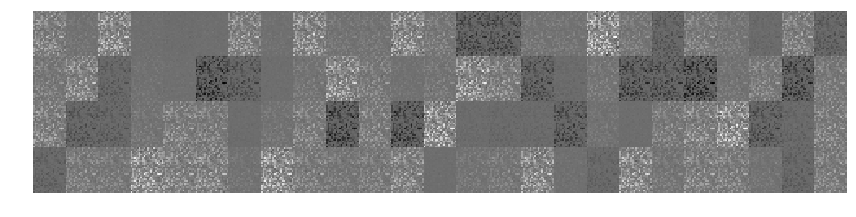

In [184]:
show_examples(outputs_val.reshape((-1, img_rows, img_cols)), n=100, n_cols=25)

In [186]:
1000*1965

1965000